In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import chromATAC as ca
from chromATAC.integrated import IntData
from functools import reduce
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings

warnings.simplefilter("ignore", category=pd.errors.ParserWarning)

In [3]:
def find_overlapping_genes(row, df2):
    overlapping_genes = df2[(df2['chr'] == row['chr']) &
                            (df2['start'] <= row['end']) &
                            (df2['end'] >= row['start'])][['gene_name', 'gene_type', 'length']].values.tolist()
    return overlapping_genes
    
def find_nearest_genes(row, df2):
    # Filter rows with the same chromosome
    matching_genes = df2[df2['chr'] == row['chr']]
    if matching_genes.empty:
        return None, None
    # Calculate distances to all genes
    matching_genes['distance_before'] = row['start'] - matching_genes['end']
    matching_genes['distance_after'] = matching_genes['start'] - row['end']
    # Find the nearest gene before and after
    nearest_gene_before = matching_genes.loc[matching_genes['distance_before'].idxmax(), ['gene_name', 'gene_type', 'length']].values.tolist()
    nearest_gene_after = matching_genes.loc[matching_genes['distance_after'].idxmin(), ['gene_name', 'gene_type', 'length']].values.tolist()
    return (nearest_gene_before, matching_genes['distance_before'].max()), (nearest_gene_after, matching_genes['distance_after'].min())

In [4]:
tes_dir = '/cluster/home/t124771uhn/data/V2-TEs/non_olap'
cotes_dir = '/cluster/home/t124771uhn/data/V2-TEs/non_olap/cores1000/'

In [5]:
TEs = np.array([i.split('.')[0] for i in os.listdir(tes_dir) if i.endswith('.bed')])
COTES = np.array([i.split('.')[0] for i in os.listdir(cotes_dir) if i.endswith('.bed')])

In [6]:
te_meta = pd.read_csv('/cluster/home/t124771uhn/analysis/repeat_metadata.onlyTEs_full.txt', sep='\t')
te_df = te_meta.iloc[np.concatenate([np.where(te_meta['repname_numbered'].apply(lambda x: i.split('_')[0]==x.split('_')[0]))[0] for i in TEs]), :].loc[:, ['repname', 'Superfamily', 'repname_numbered']].copy()
te_df.index = range(1, len(te_df)+1)
te_df['COTE'] = te_df['repname_numbered'].apply(lambda x: x.split('_')[0] in np.array([i.split('_')[0] for i in np.intersect1d(TEs, COTES)]))
te_df.loc[971] = ['ERV3-16A3_I-int', 'ERVL', '369_ERV3-16A3_I-int', True]

In [7]:
te_n_elements = pd.read_csv(tes_dir+'/n_elements_per_TE.txt', sep='\t', header=None, names = ['name', 'n_elements'])
cote_n_elments = pd.read_csv(cotes_dir+'/n_clusters_per_TE.txt', sep='\t', header=None, names = ['name', 'n_clusters'])

In [8]:
te_n_elements['name'] = te_n_elements['name'].apply(lambda x: x.split('_Merged.bed')[0])
cote_n_elments['name'] = cote_n_elments['name'].apply(lambda x: x.split('_Merged.bed')[0])
te_df = te_df.merge(te_n_elements, how='left', left_on='repname_numbered', right_on='name').merge(cote_n_elments, how='left', left_on='repname_numbered', right_on='name').drop(['name_x', 'name_y'], axis=1).fillna(0)

In [9]:
te_df
te_df['overlapping_genes']= None
te_df['nearest_gene_before'] = None
te_df['nearest_gene_after'] = None

In [10]:
te_df

,repname,Superfamily,repname_numbered,COTE,n_elements,n_clusters,overlapping_genes,nearest_gene_before,nearest_gene_after
0,LTR14B,ERV2,688_LTR14B,False,372,0.0,None,None,None
1,ERVL-int,ERV3,374_ERVL-int,False,873,0.0,None,None,None
2,THE1B-int,ERV3,1363_THE1B-int,True,4298,52.0,None,None,None
3,HERVE_a-int,ERV1,475_HERVE_a-int,False,198,0.0,None,None,None
4,Penelope1_Vert,LINE,1229_Penelope1_Vert,True,1113,30.0,None,None,None
...,...,...,...,...,...,...,...,...,...
966,MER91B,Transposons,1117_MER91B,True,1615,61.0,None,None,None
967,LTR57-int,ERV3,815_LTR57-int,False,381,0.0,None,None,None
968,Kanga2_a,Transposons,515_Kanga2_a,True,1551,28.0,None,None,None
969,MLT1F1-int,ERV3,1162_MLT1F1-int,False,178,0.0,None,None,None


In [10]:
means = te_df.groupby(by='Superfamily').mean('n_clusters').drop(['COTE'], axis=1)

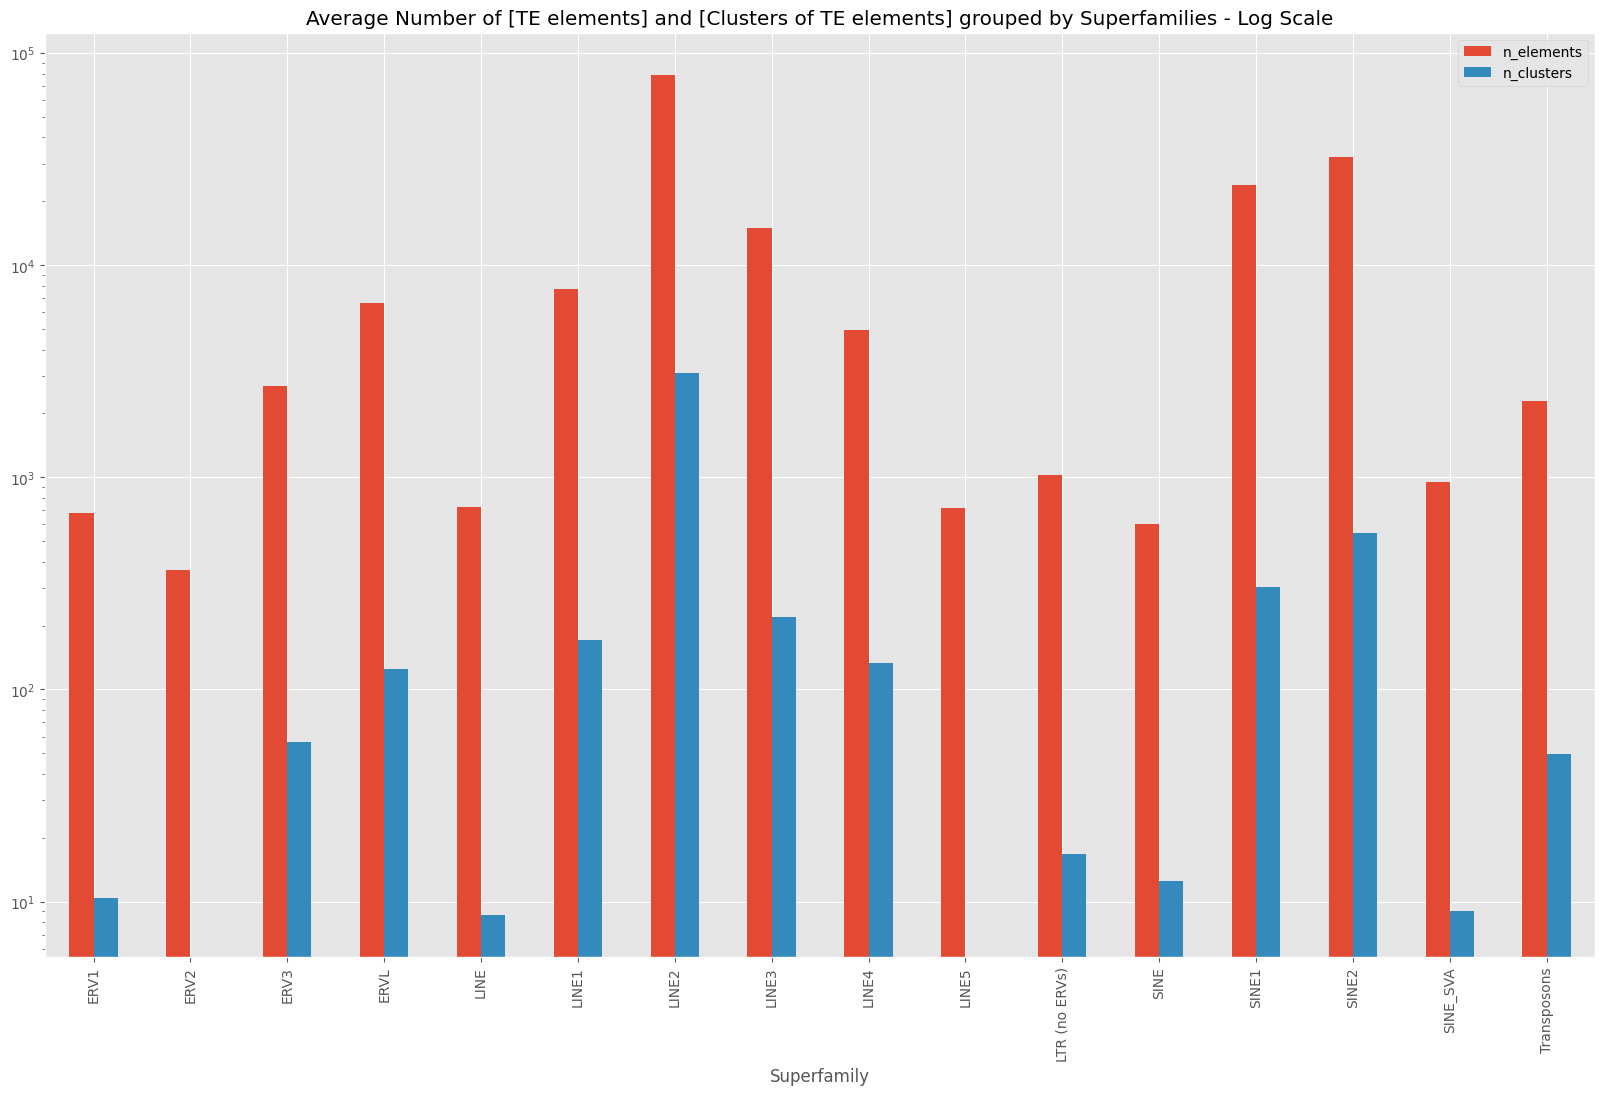

In [28]:
fig, axs = plt.subplots(figsize=(20, 12))
means.plot(kind='bar', logy=True, ax=axs)
plt.title('Average Number of [TE elements] and [Clusters of TE elements] grouped by Superfamilies - Log Scale')
fig.savefig('./mean_n_elements.png',  bbox_inches='tight')

In [95]:
te_meta

,Unnamed: 0,repname,Superfamily,repname_numbered,COTE,n_elements,n_clusters,overlapping_genes,nearest_gene_before,nearest_gene_after
0,0,LTR14B,ERV2,688_LTR14B,False,372.0,0.0,"[[TAS1R1, protein_coding, 24448.0], [TAS1R1, p...","{('WBP1LP12', 'processed_pseudogene', 330.0), ...","{('WBP1LP12', 'processed_pseudogene', 330.0), ..."
1,1,ERVL-int,ERV3,374_ERVL-int,False,873.0,0.0,"[[ENSG00000290385, lncRNA, 157539.0], [ENSG000...","{('WBP1LP12', 'processed_pseudogene', 330.0), ...","{('WBP1LP12', 'processed_pseudogene', 330.0), ..."
2,2,THE1B-int,ERV3,1363_THE1B-int,True,4298.0,52.0,"[[ENSG00000290385, lncRNA, 157539.0], [ENSG000...","{('WBP1LP12', 'processed_pseudogene', 330.0), ...","{('WBP1LP12', 'processed_pseudogene', 330.0), ..."
3,3,HERVE_a-int,ERV1,475_HERVE_a-int,False,198.0,0.0,"[[AMY1C, protein_coding, 13403.0], [AMY1C, pro...","{('WBP1LP12', 'processed_pseudogene', 330.0), ...","{('WBP1LP12', 'processed_pseudogene', 330.0), ..."
4,4,Penelope1_Vert,LINE,1229_Penelope1_Vert,True,1113.0,30.0,"[[CAMTA1, protein_coding, 984252.0], [H6PD, pr...","{('WBP1LP12', 'processed_pseudogene', 330.0), ...","{('WBP1LP12', 'processed_pseudogene', 330.0), ..."
...,...,...,...,...,...,...,...,...,...,...
966,966,MER91B,Transposons,1117_MER91B,True,1615.0,61.0,"[[ENSG00000241860, lncRNA, 32388.0], [ENSG0000...","{('WBP1LP12', 'processed_pseudogene', 330.0), ...","{('WBP1LP12', 'processed_pseudogene', 330.0), ..."
967,967,LTR57-int,ERV3,815_LTR57-int,False,381.0,0.0,"[[ENSG00000233755, lncRNA, 69413.0], [ENSG0000...","{('WBP1LP12', 'processed_pseudogene', 330.0), ...","{('WBP1LP12', 'processed_pseudogene', 330.0), ..."
968,968,Kanga2_a,Transposons,515_Kanga2_a,True,1551.0,28.0,"[[AJAP1, protein_coding, 137925.0], [DLGAP3, p...","{('WBP1LP12', 'processed_pseudogene', 330.0), ...","{('WBP1LP12', 'processed_pseudogene', 330.0), ..."
969,969,MLT1F1-int,ERV3,1162_MLT1F1-int,False,178.0,0.0,"[[LINC01777, lncRNA, 12662.0], [TNFRSF1B, prot...","{('WBP1LP12', 'processed_pseudogene', 330.0), ...","{('WBP1LP12', 'processed_pseudogene', 330.0), ..."


In [12]:
gtf = pd.read_csv("/cluster/projects/lupiengroup/People/mossi/data/GTF/V2_gencode.v44.annotation.gff3", sep = '\t', index_col=0)
gtf = gtf[gtf.type=='gene'].loc[:, ['chr', 'start', 'end', 'gene_name', 'gene_type']]
gtf = gtf[gtf['chr'].apply(lambda x: x in ca.info.CHROMOSOMES['names'])]
gtf['length']=gtf['end']-gtf['start']

In [13]:
te_meta = pd.read_csv('/cluster/home/t124771uhn/projects/chromATAC/chromATAC/scripts/slurm/te_metadata.csv', sep='\t').dropna()

In [122]:
def plot_gene_types(df, group_key, nested_col='overlapping_genes', threshold=0.01, style='default', pos):
    colors = [
    "red", "steelblue", "purple", "orange", 
    "magenta", "teal", "lavender", "brown", 
    "gold", "navy", "maroon", 
     "darkred", "darkblue",
    "darkgreen", "darkgoldenrod",
    "royalblue", "mediumseagreen"
    ]

    if df[nested_col].dtype == 'O':  # Check if the type is object (which usually indicates a string in pandas)
        df[nested_col] = df[nested_col].apply(lambda x: eval(x) if isinstance(x, str) else x)
    
    # Extract all gene types and distances for each group
    gene_data = {}
    others_data = {}
    for group, sub_df in df.groupby(group_key):
        all_gene_types = [item[1] for sublist in sub_df[nested_col].tolist() for item in sublist]
        
        gene_types = list(set(all_gene_types))
        total_count = len(all_gene_types)
        major_gene_types = {gene: all_gene_types.count(gene) for gene in gene_types if all_gene_types.count(gene) / total_count >= threshold}
        minor_gene_types = {gene: all_gene_types.count(gene) for gene in gene_types if all_gene_types.count(gene) / total_count < threshold}
        
        gene_data[group] = major_gene_types
        gene_data[group]['Others'] = sum(minor_gene_types.values())
        
        others_data[group] = minor_gene_types
    
    plt.style.use(style)  # Applying the desired plot style
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 16))
    for idx, (data, title) in enumerate(zip([gene_data, others_data], [f"Major Categories of Genes {pos} the TE's elements + Others", 'Only "Others" Categories'])):
        ax = axes[idx]
        bar_width = 0.35
        index = np.arange(len(data))

        bottom_count = np.zeros(len(data))
        custom_patches = []  # For custom legends

        for color_idx, gene in enumerate(data[list(data.keys())[0]]):
            counts = [data[group][gene] if gene in data[group] else 0 for group in data]
            total_counts = [sum(data[group].values()) for group in data]
            counts_percent = [count / total * 100 for count, total in zip(counts, total_counts)]
            color = colors[color_idx % len(colors)]  # Cycle through the provided colors
            if any(counts_percent):
                ax.bar(index, counts_percent, bar_width, label=gene, bottom=bottom_count, alpha=0.6, color=color)
                custom_patches.append(plt.Rectangle((0, 0), 1, 1, fc=color, label=gene))
            bottom_count += counts_percent
        ax.set_xlabel(group_key)
        ax.set_ylabel('Percentage (%)')
        ax.set_title(f'Gene Types Distribution by {group_key} ({title})')
        ax.set_xticks(index)
        ax.set_xticklabels(list(data.keys()))
        # Use custom_patches for the legend
        ax.legend(handles=custom_patches, loc='lower left', bbox_to_anchor=(0, 1.06, 1, 0.2), mode='expand', ncol=3, borderaxespad=0)
    plt.tight_layout()
    plt.show()
    fig.savefig(f'./tes_{pos}_gen.png')

In [133]:
def plot_gene_types_stacked(df, group_key, nested_cols, threshold=0.01, style='default', pos=''):
    colors = [
        "red", "steelblue", "purple", "orange", 
        "magenta", "teal", "lavender", "brown", 
        "gold", "navy", "maroon", 
        "darkred", "darkblue",
        "darkgreen", "darkgoldenrod",
        "royalblue", "mediumseagreen"
    ]

    data_dict = {}

    for nested_col in nested_cols:
        if df[nested_col].dtype == 'O':
            df[nested_col] = df[nested_col].apply(lambda x: eval(x) if isinstance(x, str) else x)
        
        gene_data = {}
        others_data = {}
        for group, sub_df in df.groupby(group_key):
            all_gene_types = [item[1] for sublist in sub_df[nested_col].tolist() for item in sublist]
            
            gene_types = list(set(all_gene_types))
            total_count = len(all_gene_types)
            major_gene_types = {gene: all_gene_types.count(gene) for gene in gene_types if all_gene_types.count(gene) / total_count >= threshold}
            minor_gene_types = {gene: all_gene_types.count(gene) for gene in gene_types if all_gene_types.count(gene) / total_count < threshold}
            
            gene_data[group] = major_gene_types
            gene_data[group]['Others'] = sum(minor_gene_types.values())
            
            others_data[group] = minor_gene_types
        
        data_dict[nested_col] = [gene_data, others_data]

    plt.style.use(style)
    fig, axes = plt.subplots(nrows=2, ncols=len(nested_cols), figsize=(15 * len(nested_cols), 16))
    
    for col_idx, nested_col in enumerate(nested_cols):
        for idx, (data, title) in enumerate(zip(data_dict[nested_col], [f"Major Categories of Genes {pos} the TE's elements + Others", 'Only "Others" Categories'])):
            ax = axes[idx, col_idx] if len(nested_cols) > 1 else axes[idx]
            bar_width = 0.35
            index = np.arange(len(data))

            bottom_count = np.zeros(len(data))
            custom_patches = []

            for color_idx, gene in enumerate(data[list(data.keys())[0]]):
                counts = [data[group][gene] if gene in data[group] else 0 for group in data]
                total_counts = [sum(data[group].values()) for group in data]
                counts_percent = [count / total * 100 for count, total in zip(counts, total_counts)]
                color = colors[color_idx % len(colors)]
                if any(counts_percent):
                    ax.bar(index, counts_percent, bar_width, label=gene, bottom=bottom_count, alpha=0.6, color=color)
                    custom_patches.append(plt.Rectangle((0, 0), 1, 1, fc=color, label=gene))
                bottom_count += counts_percent
            ax.set_xlabel(group_key)
            ax.set_ylabel('Percentage (%)')
            ax.set_title(f'Gene Types Distribution for {nested_col} by {group_key} ({title})')
            ax.set_xticks(index)
            ax.set_xticklabels(list(data.keys()))
            ax.legend(handles=custom_patches, loc='lower left', bbox_to_anchor=(0, 1.06, 1, 0.2), mode='expand', ncol=3, borderaxespad=0)
    plt.tight_layout()
    plt.show()
    fig.savefig(f'./tes_{pos}_gen.png')

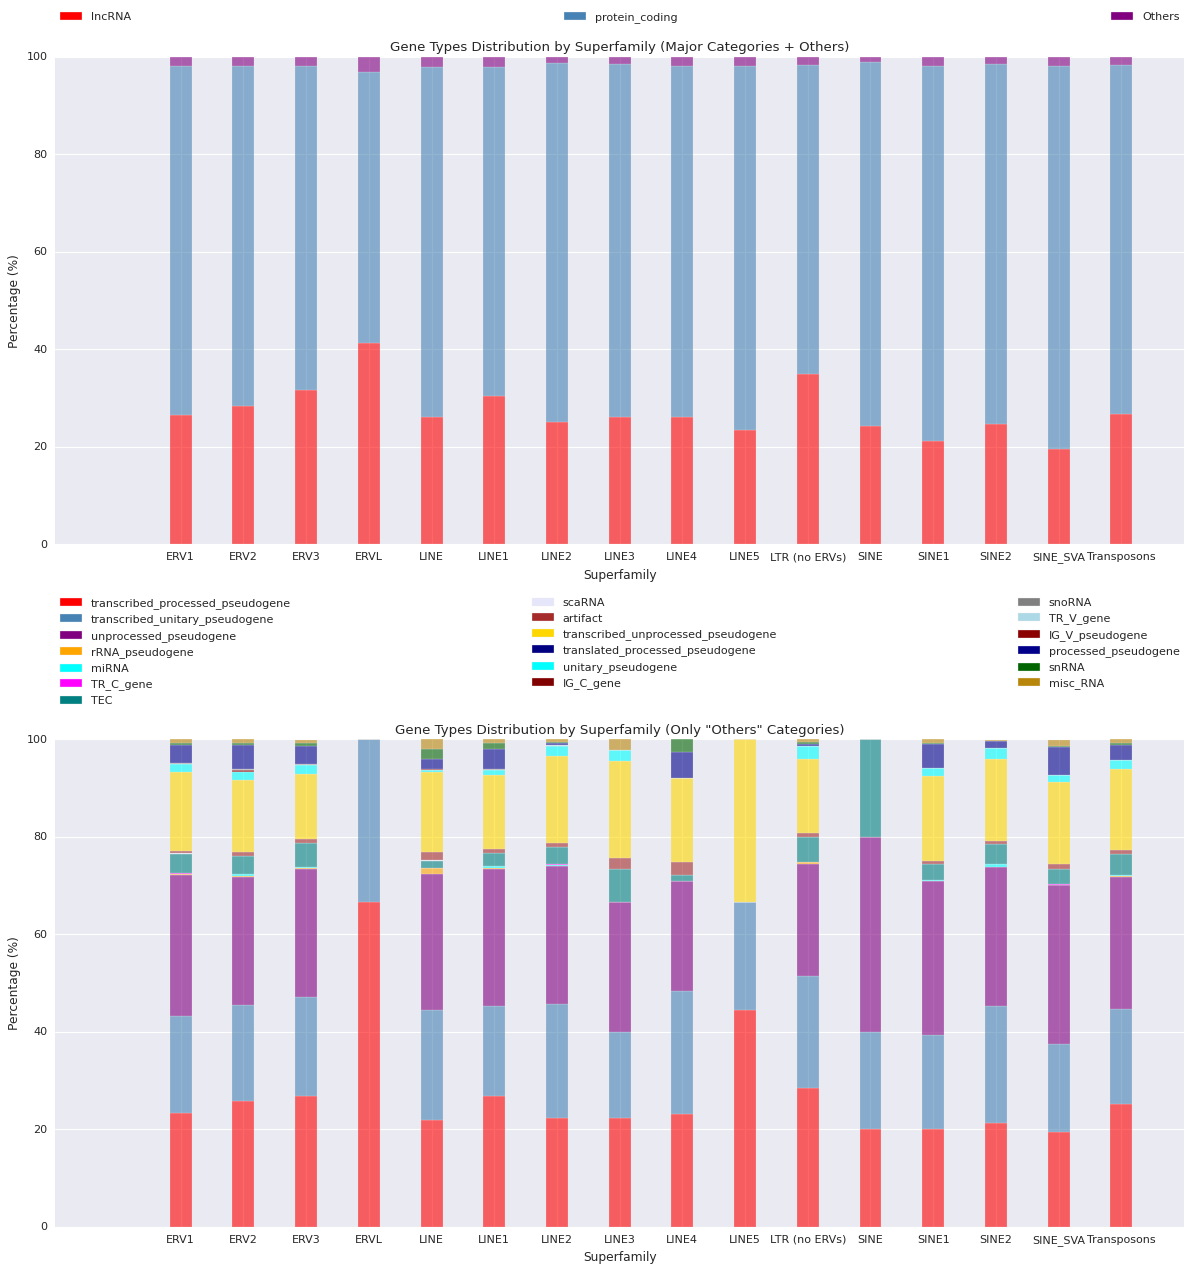

In [94]:
plot_gene_types(te_meta, 'Superfamily', style='seaborn-v0_8')

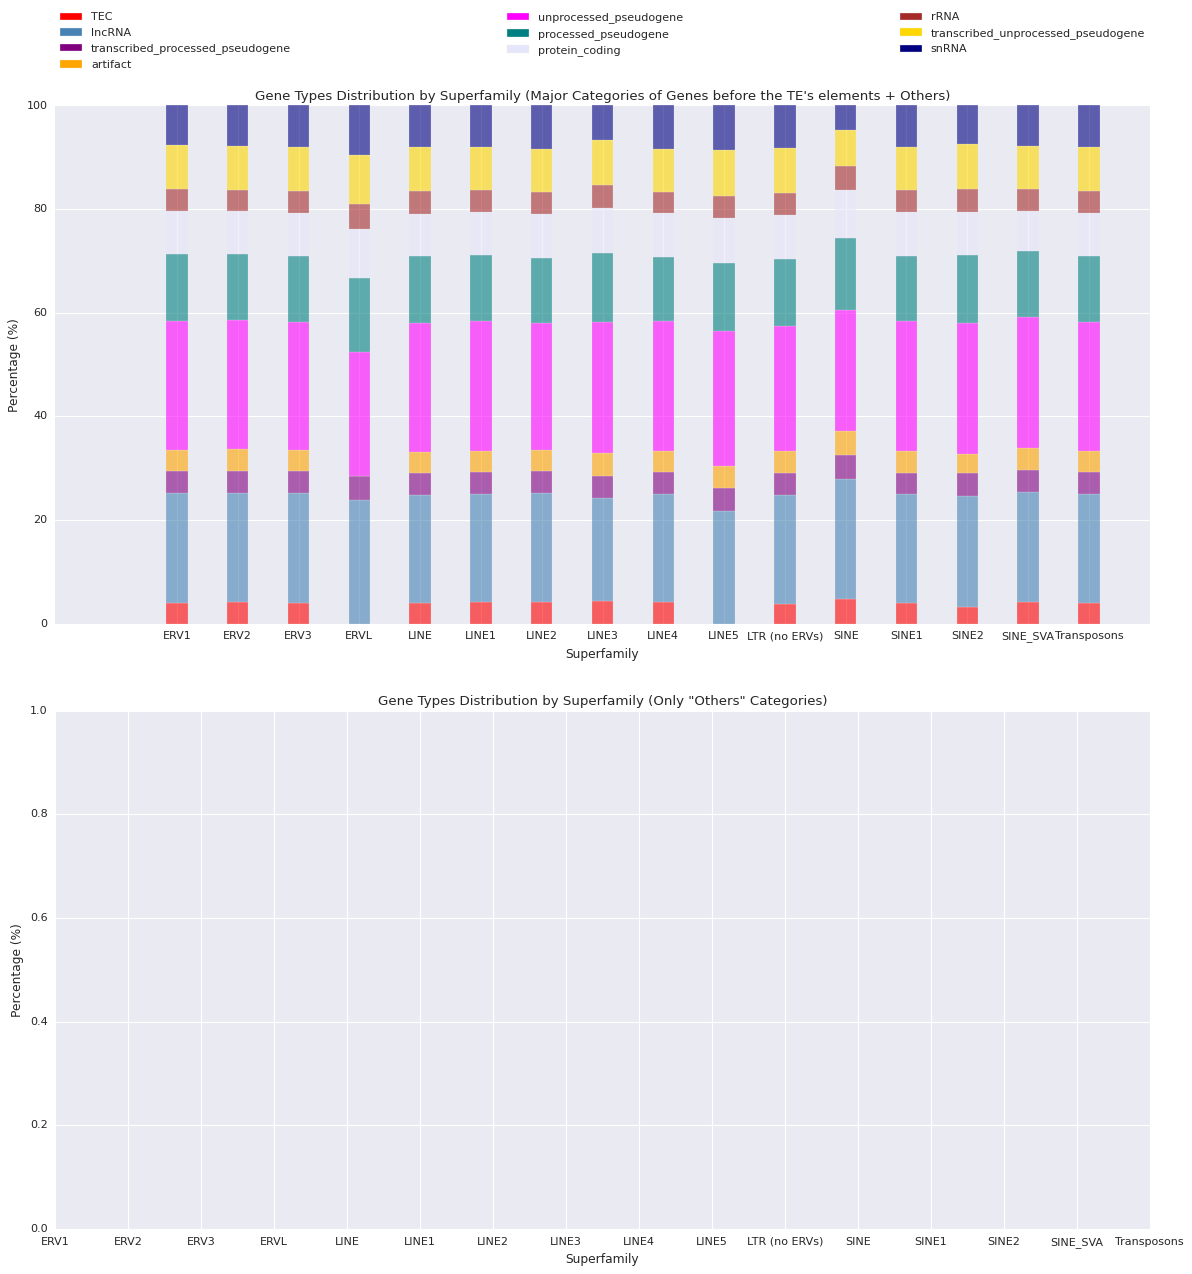

In [123]:
plot_gene_types(te_meta, 'Superfamily',  nested_col = 'nearest_gene_before', style='seaborn-v0_8', pos='before')

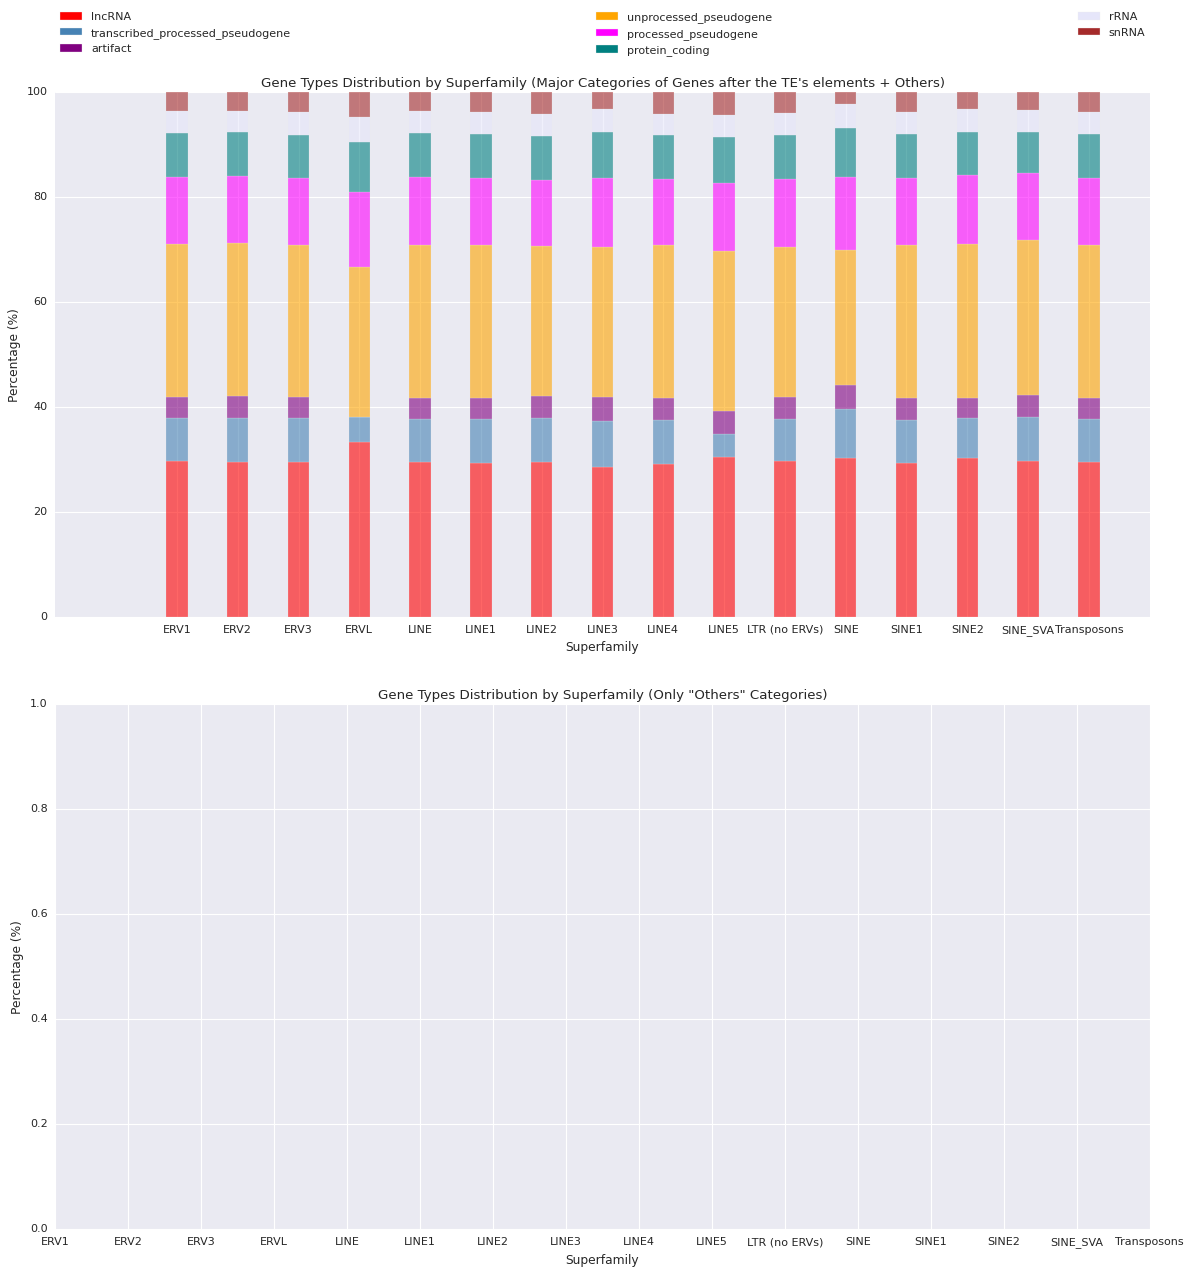

In [124]:
plot_gene_types(te_meta, 'Superfamily',  nested_col = 'nearest_gene_after', style='seaborn-v0_8', pos='after')

In [160]:
def plot_gene_types_grouped_with_annotations(df, group_key, nested_cols, threshold=0.01, style='default', pos='', annotate=True):
    colors = [
        "red", "steelblue", "purple", "orange", 
        "magenta", "teal", "lavender", "brown", 
        "gold", "navy", "maroon", 
        "darkred", "darkblue",
        "darkgreen", "darkgoldenrod",
        "royalblue", "mediumseagreen"
    ]

    all_genes = []
    for nested_col in nested_cols:
        if df[nested_col].dtype == 'O':
            df[nested_col] = df[nested_col].apply(lambda x: eval(x) if isinstance(x, str) else x)
        all_genes.extend([item[1] for sublist in df[nested_col].tolist() for item in sublist])
    unique_genes = list(set(all_genes))
    gene_color_mapping = {gene: colors[i % len(colors)] for i, gene in enumerate(unique_genes)}

    data_dict = {}
    for nested_col in nested_cols:
        gene_data = {}
        others_data = {}
        for group, sub_df in df.groupby(group_key):
            all_gene_types = [item[1] for sublist in sub_df[nested_col].tolist() for item in sublist]
            
            gene_types = list(set(all_gene_types))
            total_count = len(all_gene_types)
            major_gene_types = {gene: all_gene_types.count(gene) for gene in gene_types if all_gene_types.count(gene) / total_count >= threshold}
            minor_gene_types = {gene: all_gene_types.count(gene) for gene in gene_types if all_gene_types.count(gene) / total_count < threshold}
            
            gene_data[group] = major_gene_types
            gene_data[group]['Others'] = sum(minor_gene_types.values())
            
            others_data[group] = minor_gene_types
        
        data_dict[nested_col] = [gene_data, others_data]

    plt.style.use(style)
    fig, ax = plt.subplots(figsize=(15, 8))
    
    bar_width = 0.35 / len(nested_cols)
    gap_width = 0.025
    groups = df[group_key].unique()
    index = np.arange(len(groups))
    
    tick_positions = []
    
    for col_idx, nested_col in enumerate(nested_cols):
        positions = (index + col_idx * bar_width + col_idx * gap_width)
        tick_positions.extend((positions + bar_width / 2)-0.08)
        
        for data_type, data in enumerate(data_dict[nested_col]):
            bottom_count = np.zeros(len(groups))
            for gene in unique_genes:
                counts = [data[group].get(gene, 0) for group in groups]
                total_counts = [sum(data[group].values()) for group in groups]
                
                counts_percent = [(count / total * 100) if total != 0 else 0 for count, total in zip(counts, total_counts)]
                
                if any(counts_percent):
                    bars = ax.bar(positions, counts_percent, bar_width, label=gene if col_idx == 0 else "", bottom=bottom_count, alpha=0.6, color=gene_color_mapping[gene])
                    # Annotate the bars
                    for idx, bar in enumerate(bars):
                        height = bar.get_height()
                        if height > 0 and annotate:
                            ax.text(bar.get_x() + bar.get_width()/2., bottom_count[idx] + height/2.,
                                    '%.1f' % float(height),
                                    ha='center', va='center', color='black', fontsize=6, rotation=90)
                bottom_count += counts_percent

    ax.set_xlabel(group_key)
    ax.set_ylabel('Percentage (%)')
    ax.set_title(f'Gene Types Distribution by {group_key}')
    
    tick_labels = [f"{group}_{col}" for col in nested_cols for group in groups]
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(tick_labels, rotation=45, ha='right')
    custom_patches = [plt.Rectangle((0, 0), 1, 1, fc=gene_color_mapping[gene], label=gene) for gene in unique_genes]
    ax.legend(handles=custom_patches, loc='lower left', bbox_to_anchor=(0, 1.06, 1, 0.2), mode='expand', ncol=3, borderaxespad=0)
    
    plt.tight_layout()
    plt.show()
    fig.savefig(f'./tes_{pos}_gen.png')

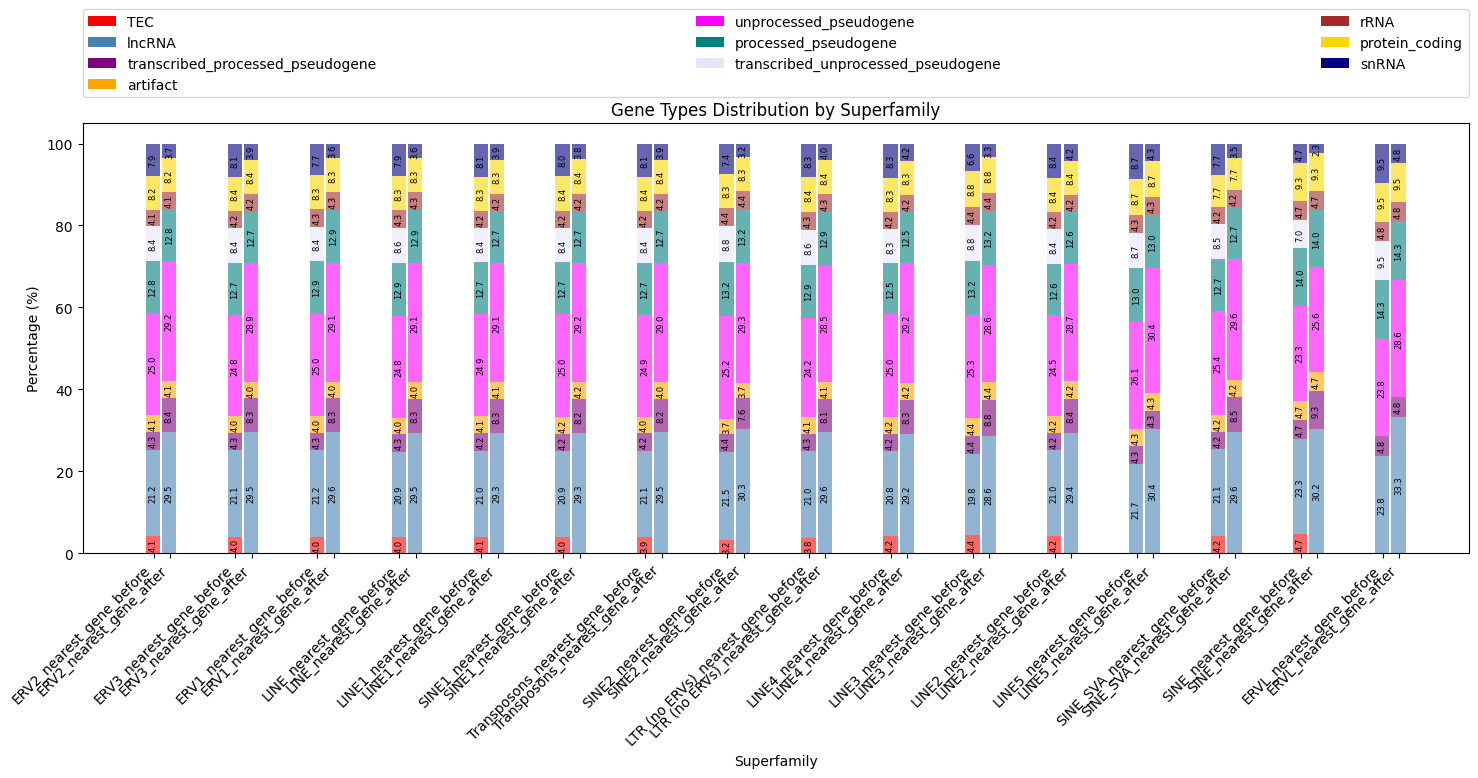

In [162]:
plot_gene_types_grouped_with_annotations(te_meta, 'Superfamily', ['nearest_gene_before', 'nearest_gene_after'], annotate=True)

<ul>
    <li><strong>transcribed_processed_pseudogene:</strong> A pseudogene that has gone through RNA transcription and processing but doesn't produce a functional protein.</li>
    <li><strong>lncRNA:</strong> Long non-coding RNA. These are RNA molecules that are longer than 200 nucleotides and do not code for proteins. They play a variety of roles in cellular processes.</li>
    <li><strong>protein_coding:</strong> Refers to genes that code for proteins.</li>
    <li><strong>transcribed_unprocessed_pseudogene:</strong> A pseudogene that has been transcribed into RNA but has not gone through the typical RNA processing steps.</li>
    <li><strong>unprocessed_pseudogene:</strong> A pseudogene that arises from the direct duplication of a parent gene and has not been processed.</li>
    <li><strong>transcribed_unitary_pseudogene:</strong> A pseudogene that is transcribed but is distinct in that it doesn't have any functional counterparts in the genome.</li>
    <li><strong>TEC:</strong> "To be Experimentally Confirmed". This denotes sequences for which the existence is supported, but the exact nature remains to be verified.</li>
    <li><strong>processed_pseudogene:</strong> A pseudogene that arises from the reverse transcription of an mRNA and then gets inserted back into the genome.</li>
    <li><strong>unitary_pseudogene:</strong> A pseudogene that has lost its protein-coding ability or was never protein-coding.</li>
    <li><strong>snoRNA:</strong> Small nucleolar RNA. These are involved in the modification and processing of other RNAs, mainly ribosomal RNAs.</li>
    <li><strong>misc_RNA:</strong> Miscellaneous RNA. This is a general category for RNAs that don't fit into other well-defined categories.</li>
    <li><strong>artifact:</strong> Typically refers to sequences that may arise from experimental or computational errors.</li>
    <li><strong>snRNA:</strong> Small nuclear RNA. They are involved in splicing of pre-mRNA.</li>
    <li><strong>rRNA_pseudogene:</strong> Pseudogenes derived from ribosomal RNA genes.</li>
    <li><strong>miRNA:</strong> MicroRNA. These are small non-coding RNAs that play a role in gene regulation.</li>
    <li><strong>TR_V_gene:</strong> T-cell receptor variable gene.</li>
    <li><strong>TR_C_gene:</strong> T-cell receptor constant gene.</li>
    <li><strong>IG_V_pseudogene:</strong> Immunoglobulin variable pseudogene.</li>
    <li><strong>IG_C_gene:</strong> Immunoglobulin constant gene.</li>
    <li><strong>scaRNA:</strong> Small Cajal body-specific RNA. They guide the modification of small nuclear RNAs (snRNAs).</li>
    <li><strong>TR_V_pseudogene:</strong> T-cell receptor variable pseudogene.</li>
</ul>


In [164]:
gtf = pd.read_csv('/cluster/projects/lupiengroup/People/mossi/data/GTF/V2_gencode.v44.annotation.gff3', sep='\t')

In [165]:
gtf

,Unnamed: 0,chr,name,type,start,end,st1,st2,st3,ID,...,gene_id,transcript_id,gene_type,gene_name,transcript_type,transcript_name,level,transcript_support_level,tag,havana_transcript
0,0,chr1,HAVANA,gene,11869.0,14409.0,.,+,.,ENSG00000290825.1,...,ENSG00000290825.1,NaN,lncRNA,DDX11L2,NaN,NaN,2.0,NaN,overlaps_pseudogene,NaN
1,1,chr1,HAVANA,transcript,11869.0,14409.0,.,+,.,ENST00000456328.2,...,ENSG00000290825.1,ENST00000456328.2,lncRNA,DDX11L2,lncRNA,DDX11L2-202,2.0,1.0,"basic,Ensembl_canonical",OTTHUMT00000362751.1
2,2,chr1,HAVANA,exon,11869.0,12227.0,.,+,.,ENST00000456328.2:1,...,ENSG00000290825.1,ENST00000456328.2,lncRNA,DDX11L2,lncRNA,DDX11L2-202,2.0,1.0,"basic,Ensembl_canonical",OTTHUMT00000362751.1
3,3,chr1,HAVANA,exon,12613.0,12721.0,.,+,.,ENST00000456328.2:2,...,ENSG00000290825.1,ENST00000456328.2,lncRNA,DDX11L2,lncRNA,DDX11L2-202,2.0,1.0,"basic,Ensembl_canonical",OTTHUMT00000362751.1
4,4,chr1,HAVANA,exon,13221.0,14409.0,.,+,.,ENST00000456328.2:3,...,ENSG00000290825.1,ENST00000456328.2,lncRNA,DDX11L2,lncRNA,DDX11L2-202,2.0,1.0,"basic,Ensembl_canonical",OTTHUMT00000362751.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3422092,3422092,chrM,ENSEMBL,transcript,15888.0,15953.0,.,+,.,ENST00000387460.2,...,ENSG00000210195.2,ENST00000387460.2,Mt_tRNA,MT-TT,Mt_tRNA,MT-TT-201,3.0,NaN,"basic,Ensembl_canonical",NaN
3422093,3422093,chrM,ENSEMBL,exon,15888.0,15953.0,.,+,.,ENST00000387460.2:1,...,ENSG00000210195.2,ENST00000387460.2,Mt_tRNA,MT-TT,Mt_tRNA,MT-TT-201,3.0,NaN,"basic,Ensembl_canonical",NaN
3422094,3422094,chrM,ENSEMBL,gene,15956.0,16023.0,.,-,.,ENSG00000210196.2,...,ENSG00000210196.2,NaN,Mt_tRNA,MT-TP,NaN,NaN,3.0,NaN,NaN,NaN
3422095,3422095,chrM,ENSEMBL,transcript,15956.0,16023.0,.,-,.,ENST00000387461.2,...,ENSG00000210196.2,ENST00000387461.2,Mt_tRNA,MT-TP,Mt_tRNA,MT-TP-201,3.0,NaN,"basic,Ensembl_canonical",NaN


In [166]:
gtf

,Unnamed: 0,chr,name,type,start,end,st1,st2,st3,ID,...,gene_id,transcript_id,gene_type,gene_name,transcript_type,transcript_name,level,transcript_support_level,tag,havana_transcript
0,0,chr1,HAVANA,gene,11869.0,14409.0,.,+,.,ENSG00000290825.1,...,ENSG00000290825.1,NaN,lncRNA,DDX11L2,NaN,NaN,2.0,NaN,overlaps_pseudogene,NaN
1,1,chr1,HAVANA,transcript,11869.0,14409.0,.,+,.,ENST00000456328.2,...,ENSG00000290825.1,ENST00000456328.2,lncRNA,DDX11L2,lncRNA,DDX11L2-202,2.0,1.0,"basic,Ensembl_canonical",OTTHUMT00000362751.1
2,2,chr1,HAVANA,exon,11869.0,12227.0,.,+,.,ENST00000456328.2:1,...,ENSG00000290825.1,ENST00000456328.2,lncRNA,DDX11L2,lncRNA,DDX11L2-202,2.0,1.0,"basic,Ensembl_canonical",OTTHUMT00000362751.1
3,3,chr1,HAVANA,exon,12613.0,12721.0,.,+,.,ENST00000456328.2:2,...,ENSG00000290825.1,ENST00000456328.2,lncRNA,DDX11L2,lncRNA,DDX11L2-202,2.0,1.0,"basic,Ensembl_canonical",OTTHUMT00000362751.1
4,4,chr1,HAVANA,exon,13221.0,14409.0,.,+,.,ENST00000456328.2:3,...,ENSG00000290825.1,ENST00000456328.2,lncRNA,DDX11L2,lncRNA,DDX11L2-202,2.0,1.0,"basic,Ensembl_canonical",OTTHUMT00000362751.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3422092,3422092,chrM,ENSEMBL,transcript,15888.0,15953.0,.,+,.,ENST00000387460.2,...,ENSG00000210195.2,ENST00000387460.2,Mt_tRNA,MT-TT,Mt_tRNA,MT-TT-201,3.0,NaN,"basic,Ensembl_canonical",NaN
3422093,3422093,chrM,ENSEMBL,exon,15888.0,15953.0,.,+,.,ENST00000387460.2:1,...,ENSG00000210195.2,ENST00000387460.2,Mt_tRNA,MT-TT,Mt_tRNA,MT-TT-201,3.0,NaN,"basic,Ensembl_canonical",NaN
3422094,3422094,chrM,ENSEMBL,gene,15956.0,16023.0,.,-,.,ENSG00000210196.2,...,ENSG00000210196.2,NaN,Mt_tRNA,MT-TP,NaN,NaN,3.0,NaN,NaN,NaN
3422095,3422095,chrM,ENSEMBL,transcript,15956.0,16023.0,.,-,.,ENST00000387461.2,...,ENSG00000210196.2,ENST00000387461.2,Mt_tRNA,MT-TP,Mt_tRNA,MT-TP-201,3.0,NaN,"basic,Ensembl_canonical",NaN
